# PhotoFiTT: Cell activity analysis

The data is assumed to be organised in folders as follows. The Subcategories are the ones that the code uses to display the data. The labels will be identical to the folder name, so the same conditions should always have the same folder name.

   ```   
   -Raw-images (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcaegory-00]
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01]
        ...
   ```

## 1. Import required dependencies

In [10]:
import os
import numpy as np
import pandas as pd
import photofitt
from photofitt import display
from photofitt.analysis import extract_activity, cumulative_activity, estimate_proportional_deviations
from photofitt.utils import power_conversion, numerical_dose
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Set the paths to the data and the output folders
- `path2images`: The path where the Raw-images are saved. For example "/home/ocb/HardDrive_4TB/PHX/SYNCHRO/Raw-images"
- `path2results`: The path where the notebook will save all the results. Once the cell activity is calculated, a CSV file together with the plots will be stored there.
- `frame_rate`: The time frame in the videos given in minutes (e.g., `frame_rate = 4`)


In [11]:
path2images = ""
path2results = "/Users/esti/Documents/PROYECTOS/PHX/PhotoFiTT/example-data/cell-activity/"
frame_rate = 4 

## Prepare the directory to save the results
os.makedirs(path2results,exist_ok=True)
os.makedirs(os.path.join(path2results, "plots"), exist_ok=True)


## 3. Calculate cell activity.
This process can take long hours depending on the number of videos to analyse. If it is already calculated, do not run this cell again and jump to the next step

In [ ]:
images_path = "/home/ocb/HardDrive_4TB/EGM/PHX/DATA/DOWNSAMPLE/CHO-SYNCHRO/scaled_1.5709_results"
frame_rate = 4 # The time gap we will use to compute all the metrics
output_path =  "/home/ocb/HardDrive_4TB/EGM/PHX/ANALYSIS/SYNCHRO/NEW-ACTIVITY"
## Parameters for activity method estimation
method="intensity"

activity_metrics = extract_activity(path2images,
                                    method="intensity",
                                    save_steps=False,
                                    enhance_contrast=True,
                                    output_path=output_path,
                                    condition=None)

## Save the results
activity_metrics.to_csv(os.path.join(path2results, "data_activity_intensity.csv"))

## 4. Analyse cell activity


### 4.1 Inspect the cell activity accross time
- `hue`:
- `hue_order`:
- `y_lim`:
- `format_extension`:

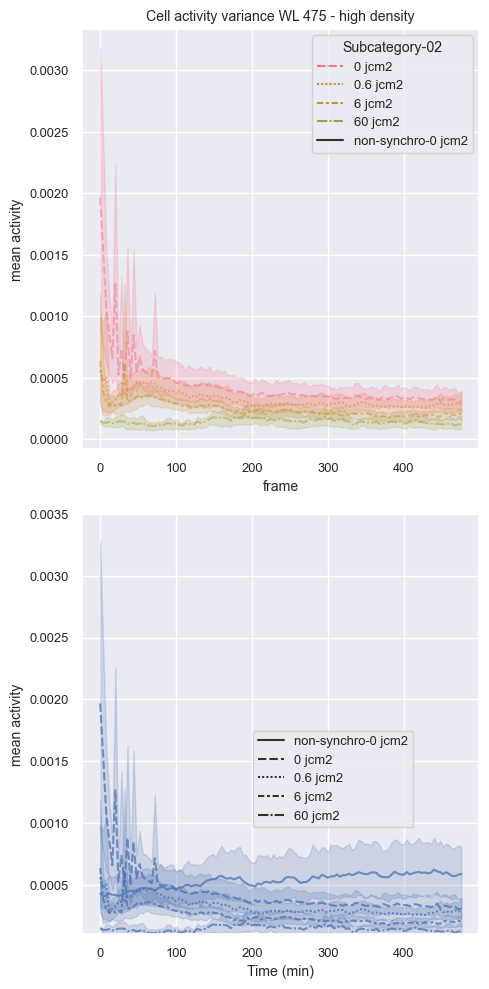

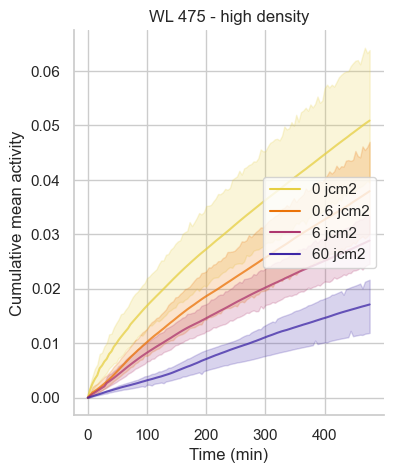

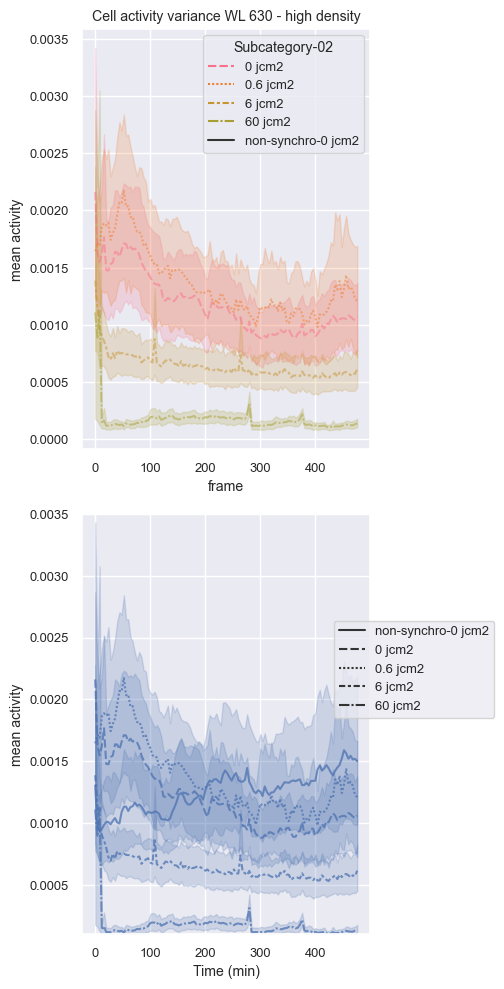

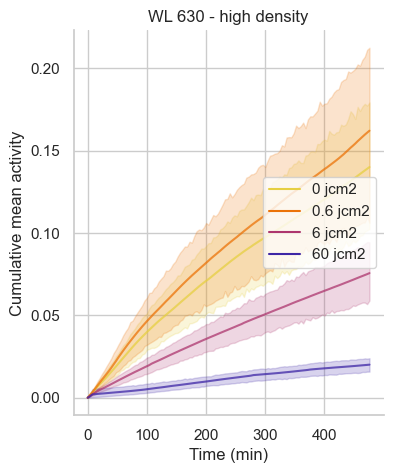

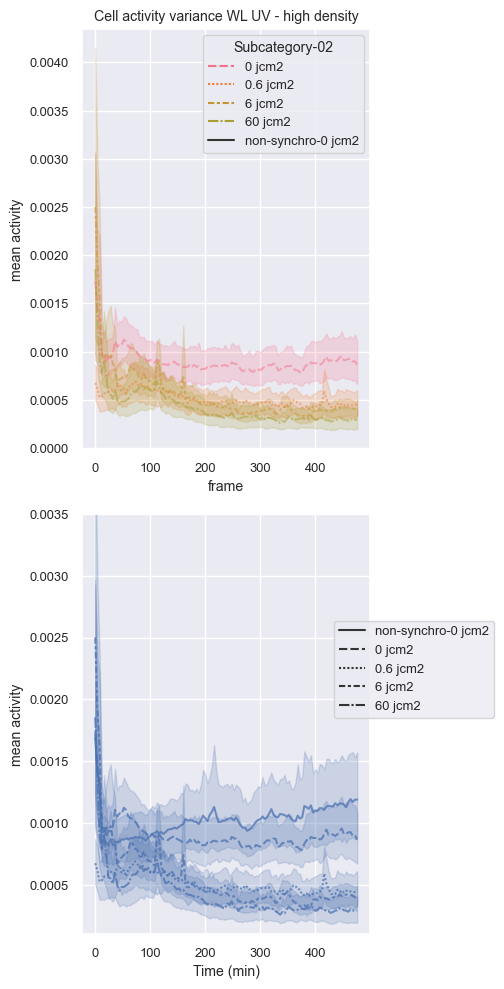

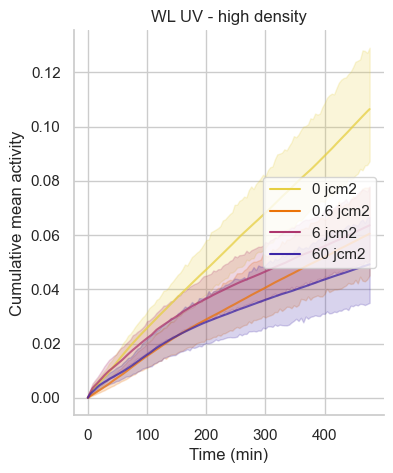

In [12]:
activity_metrics = pd.read_csv(os.path.join(path2results, "data_activity_intensity.csv"))

# If the data was organised as indicated, Subcategory-01 corresponds to the wavelength (e.g., 385nm illumination)
wavelength = np.unique(activity_metrics["Subcategory-01"])

hue="Subcategory-02" # It's the variable that corresponds to the light dose (e.g., 60 J/cm2)
hue_order = ['0 jcm2','0.6 jcm2', '6 jcm2', '60 jcm2'] # Establish your own order if needed.
ylim = [0.0001, 0.0035] # This is the y-axis limit to plot everything similarly. Addapt it as needed. 
format_extension = 'pdf' # Format to save the plots.

for w in wavelength:
    activity_w = activity_metrics[activity_metrics["Subcategory-01"]==w].reset_index(drop=True)    

    # Plot the temporal distribution of the activity
    y = "mean activity" # Variable to display
    display.conditions_with_aggregates(activity_w, y,
                               f"Cell activity variance {w}",
                               os.path.join(path2results, "plots"),
                               f"activity_variance_{w}.png",
                               hue=hue, 
                               hue_order=hue_order,
                               ylim = ylim)
    
    ## Plot additive activity
    activity_w_dataframe, activity_w = cumulative_activity(activity_w, y, use_starting_point="None", starting_point=0)
    
    y_var = f"Cumulative {y}"
    name = "cell_cumulative_activity_{0}.{1}".format(w, format_extension)
    title = f"{w}"
    display.conditions(activity_w, y_var, 
                       title, 
                       hue,
                       os.path.join(path2results, "plots"),
                       name, 
                       hue_order=hue_order,
                       palette=sns.color_palette("CMRmap_r", len(hue_order)), # change the palette if desired
                       figsize=(4, 5)) # Change the aspect ratio of the figure if desired 
    

### 4.2 Display the cummulative cell activity at a specific timepoint
- `t`: The time-point at which the differences in activity will be evaluated, in the same unit as the frame_rate given (e.g., minutes)
- `variable`: The variable for which the proportional differences will be calculated. In our case it was `'Cumulative mean activity'`.
- `grouping_variable`: The differences are calculated on average by replica (the grouping variable). In our case, following the data structure, it should be `"Subcategory-00"`.
- `reference_variable`: The variable in the data-frame that encodes the conditions and that will be displayed. In our case, it is `"Subcategory-02"`.
- `reference_category`: The reference condition used to calculate the differences. In our case, it is the control `'0 J/cm2'`.
- `unique_id_var`: We use it to identify individual videos and get statistics across them. In our case, it is `"video_name"`.
- `add_columns`: List of the columns from the original dataset that we want to preserve in the new `activity_diff` data frame.

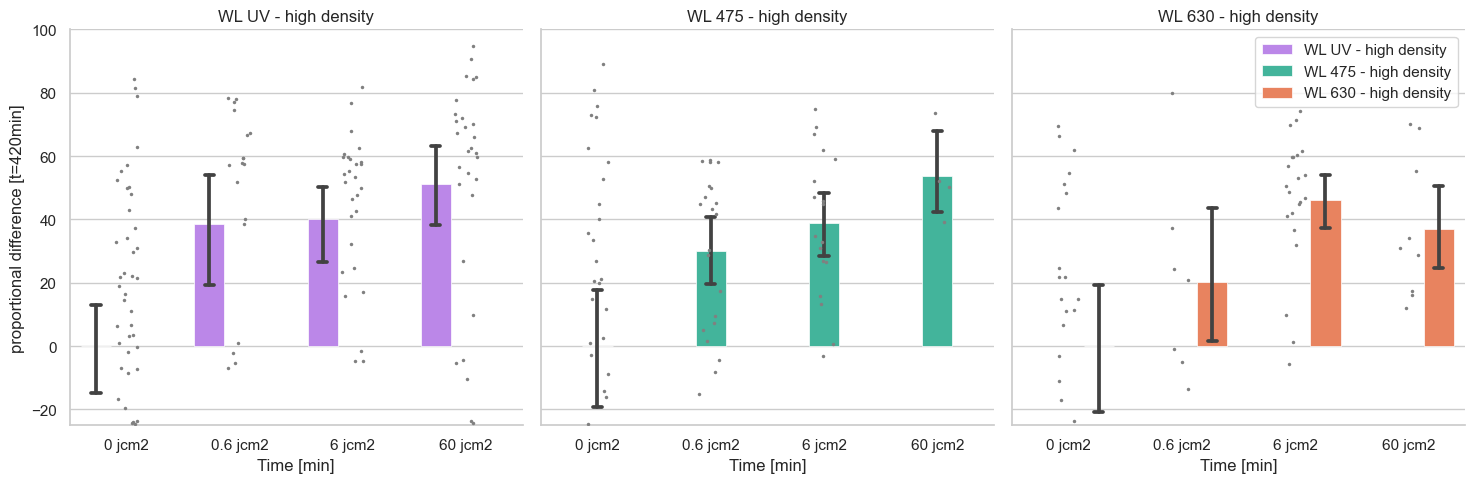

In [13]:
t = 420
activity_metrics = pd.read_csv(os.path.join(path2results, "data_activity_intensity.csv"))
## Calculate the cumulative cell activity
y = "mean activity"
activity_dataframe, activity = cumulative_activity(activity_metrics, y, use_starting_point="None")
### Filter out the data for a specfic timepoint t.
activity = activity.loc[lambda activity: activity["frame"]==t]

variable = 'Cumulative mean activity'
grouping_variable="Subcategory-00"
reference_category='0 jcm2'
reference_variable="Subcategory-02"
unique_id_var = "video_name"
add_columns = ["Subcategory-01"]
## Calculate the deviations in cell activity
activity_diff = estimate_proportional_deviations(activity,
                                                 variable,
                                                 reference_category=reference_category,
                                                 reference_variable=reference_variable,
                                                 unique_id_var=unique_id_var,
                                                 grouping_variable=grouping_variable,
                                                 add_columns=add_columns) ## add




palette_colours = ['#BC77F8', '#30C7A6', '#FF7848'] # colors for the wavelengths
wl_order = ['WL UV - high density', 'WL 475 - high density', 'WL 630 - high density'] # Column order in the plot, corresponding to the wavelengths
wl_column = "Subcategory-01" # Name of the category to consider when plotting the columns.
hue_order = ['0 jcm2', '0.6 jcm2', '6 jcm2', '60 jcm2'] # Order in which the conditions will be displayed.
y_lim = [-25, 100] # Choose the y-axis limits in the plot
format_extension = "pdf" # Choose between "pdf" and "png"

# PLOT
g = sns.catplot(
    activity_diff, kind="bar",
    x=reference_variable, 
    y=f"proportional_difference_per_{unique_id_var}",
    col=wl_column,
    hue=wl_column,
    order=hue_order,
    col_order=wl_order,
    palette=palette_colours,
    errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
    hue_order=wl_order, legend=False
)
g.map_dataframe(sns.stripplot,
            x=reference_variable,
            y=f"proportional_difference_per_{unique_id_var}",
            order=hue_order,
            jitter=True,
            dodge=False,
            marker='.',
            color="gray",
            alpha=1)
plt.tight_layout()
g.fig.get_axes()[-1].legend(loc='upper right')
g.set(xlabel="Time [min]", ylabel=f"proportional difference [t={t}min]", ylim=y_lim)
g.set_titles("{col_name}")
g.savefig(os.path.join(path2results, "plots", f"barplots_{variable}_differences_t{t}.{format_extension}"), format=format_extension, transparent=True)
plt.show()


### 4.3 Obtain basic statistics


#### Mean values

In [14]:
activity_diff.groupby(["Subcategory-01", "Subcategory-02"]).mean()


mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                      
WL 475 - high density 0 jcm2                                   0.046360   
                      0.6 jcm2                                 0.034015   
                      6 jcm2                                   0.026093   
                      60 jcm2                                  0.015360   
                      non-synchro-0 jcm2                       0.055298   
WL 630 - high density 0 jcm2                                   0.125396   
                      0.6 jcm2                                 0.144236   
                      6 jcm2                                   0.067715   
                      60 jcm2                                  0.018444   
                      non-synchro-0 jcm2                       0.128371   
WL UV - high density  0 jcm2                                   0.093675   
                      0.6 jcm2                                 0.054261   
                      6 jcm2                                   0.057885   
                      60 jcm2                                  0.045105   
                      non-synchro-0 jcm2                       0.104643   

                                          Subcategory-00 mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                                     
WL 475 - high density 0 jcm2                                                  0.046360   
                      0.6 jcm2                                                0.034015   
                      6 jcm2                                                  0.026093   
                      60 jcm2                                                 0.015360   
                      non-synchro-0 jcm2                                      0.055298   
WL 630 - high density 0 jcm2                                                  0.125396   
                      0.6 jcm2                                                0.144236   
                      6 jcm2                                                  0.067715   
                      60 jcm2                                                 0.018444   
                      non-synchro-0 jcm2                                      0.128371   
WL UV - high density  0 jcm2                                                  0.093675   
                      0.6 jcm2                                                0.054261   
                      6 jcm2                                                  0.057885   
                      60 jcm2                                                 0.045105   
                      non-synchro-0 jcm2                                      0.104643   

                                          normalised_mean_per_video_name_wrt_0 jcm2  \
Subcategory-01        Subcategory-02                                                  
WL 475 - high density 0 jcm2                                               1.000000   
                      0.6 jcm2                                             0.700597   
                      6 jcm2                                               0.610788   
                      60 jcm2                                              0.461505   
                      non-synchro-0 jcm2                                   1.098261   
WL 630 - high density 0 jcm2                                               1.000000   
                      0.6 jcm2                                             0.796382   
                      6 jcm2                                               0.538850   
                      60 jcm2                                              0.629041   
                      non-synchro-0 jcm2                                   1.460209   
WL UV - high density  0 jcm2                                               1.000000   
                      0.6 jcm2                                             0.615745   
                 

#### Standard deviation values

In [15]:
print("Standard deviation values of all the calculated metrics")
activity_diff.groupby(["Subcategory-01", "Subcategory-02"]).std()

Standard deviation values of all the calculated metrics


mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                      
WL 475 - high density 0 jcm2                                   0.034233   
                      0.6 jcm2                                 0.018391   
                      6 jcm2                                   0.009388   
                      60 jcm2                                  0.004814   
                      non-synchro-0 jcm2                       0.056394   
WL 630 - high density 0 jcm2                                   0.095428   
                      0.6 jcm2                                 0.065154   
                      6 jcm2                                   0.039552   
                      60 jcm2                                  0.006555   
                      non-synchro-0 jcm2                       0.118702   
WL UV - high density  0 jcm2                                   0.069298   
                      0.6 jcm2                                 0.034879   
                      6 jcm2                                   0.034784   
                      60 jcm2                                  0.041106   
                      non-synchro-0 jcm2                       0.091721   

                                          Subcategory-00 mean Cumulative mean activity  \
Subcategory-01        Subcategory-02                                                     
WL 475 - high density 0 jcm2                                                  0.011506   
                      0.6 jcm2                                                0.014872   
                      6 jcm2                                                  0.000665   
                      60 jcm2                                                 0.000000   
                      non-synchro-0 jcm2                                      0.024882   
WL 630 - high density 0 jcm2                                                  0.068496   
                      0.6 jcm2                                                0.050698   
                      6 jcm2                                                  0.027840   
                      60 jcm2                                                 0.000000   
                      non-synchro-0 jcm2                                      0.059612   
WL UV - high density  0 jcm2                                                  0.034776   
                      0.6 jcm2                                                0.004695   
                      6 jcm2                                                  0.025263   
                      60 jcm2                                                 0.014359   
                      non-synchro-0 jcm2                                      0.041556   

                                          normalised_mean_per_video_name_wrt_0 jcm2  \
Subcategory-01        Subcategory-02                                                  
WL 475 - high density 0 jcm2                                               0.610221   
                      0.6 jcm2                                             0.247885   
                      6 jcm2                                               0.231116   
                      60 jcm2                                              0.144638   
                      non-synchro-0 jcm2                                   0.931903   
WL 630 - high density 0 jcm2                                               0.518485   
                      0.6 jcm2                                             0.318385   
                      6 jcm2                                               0.212101   
                      60 jcm2                                              0.223579   
                      non-synchro-0 jcm2                                   1.183358   
WL UV - high density  0 jcm2                                               0.521730   
                      0.6 jcm2                                             0.396169   
                 